# Capstone Project : In-depth Analysis (Machine Learning)

> This section serves a tool to demonstrate utilizing supervised learning techniques to build  predictive models.


## Table of Contents
1. [Introduction](#intro)<br>
2. [preprocess Data](#pre)<br>
   2.1 [Access Collinearity](#ac)<br>
   2.2 [Normalising & Standardising](#sn)<br> 
3. [Evaluating and Comparing Machine Learning Models](#ecml)<br>
   3.1 [Models to Evaluate](#me)<br>
   3.2 [Model Optimization](#mo)<br>
   3.2.1 [Hyperparameters](#h)<br>
   3.2.2 [Feature Reduction](#fr)<br>  
4. [Conclusion & Recommandation](#cr)<br>

# 1. Introduction and Prodiction 
<a id="intro"> </a>
In this series of notebooks, we are working on a supervised, regression machine learning problem. Using real-world Airbnb listing data, we want to predict the yield of a list and determine the factors that influence the score.

In [495]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold


# 2. PreProcess Data
<a id="pre"> </a>
After loading the data, we will recode the categorical features into dummy features. Then we will take a look at the multi-collinearity for our data, the transformed data have 103 features. Some of the features are highly correlated, and maybe they contain the same or similar information, so we will consider keeping one from them to represent information for a certain perspective. Also, we want to avoid the curse of dimensionality to keep only necessary input information for our model.

In [475]:
# we define the heatmap function to visualize the 
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """    
    # Set the style of the visualization
    sns.set(style="white")
    # Create a covariance matrix
    corr = df.corr()
    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max()
               );
    
    
# load the data
listings_model = pd.read_csv('listings_clean_model.csv')

# transform categorical data into dummy
transformed_listings = pd.get_dummies(listings_model)

## 2.1 Assessed for multi-collinearity.

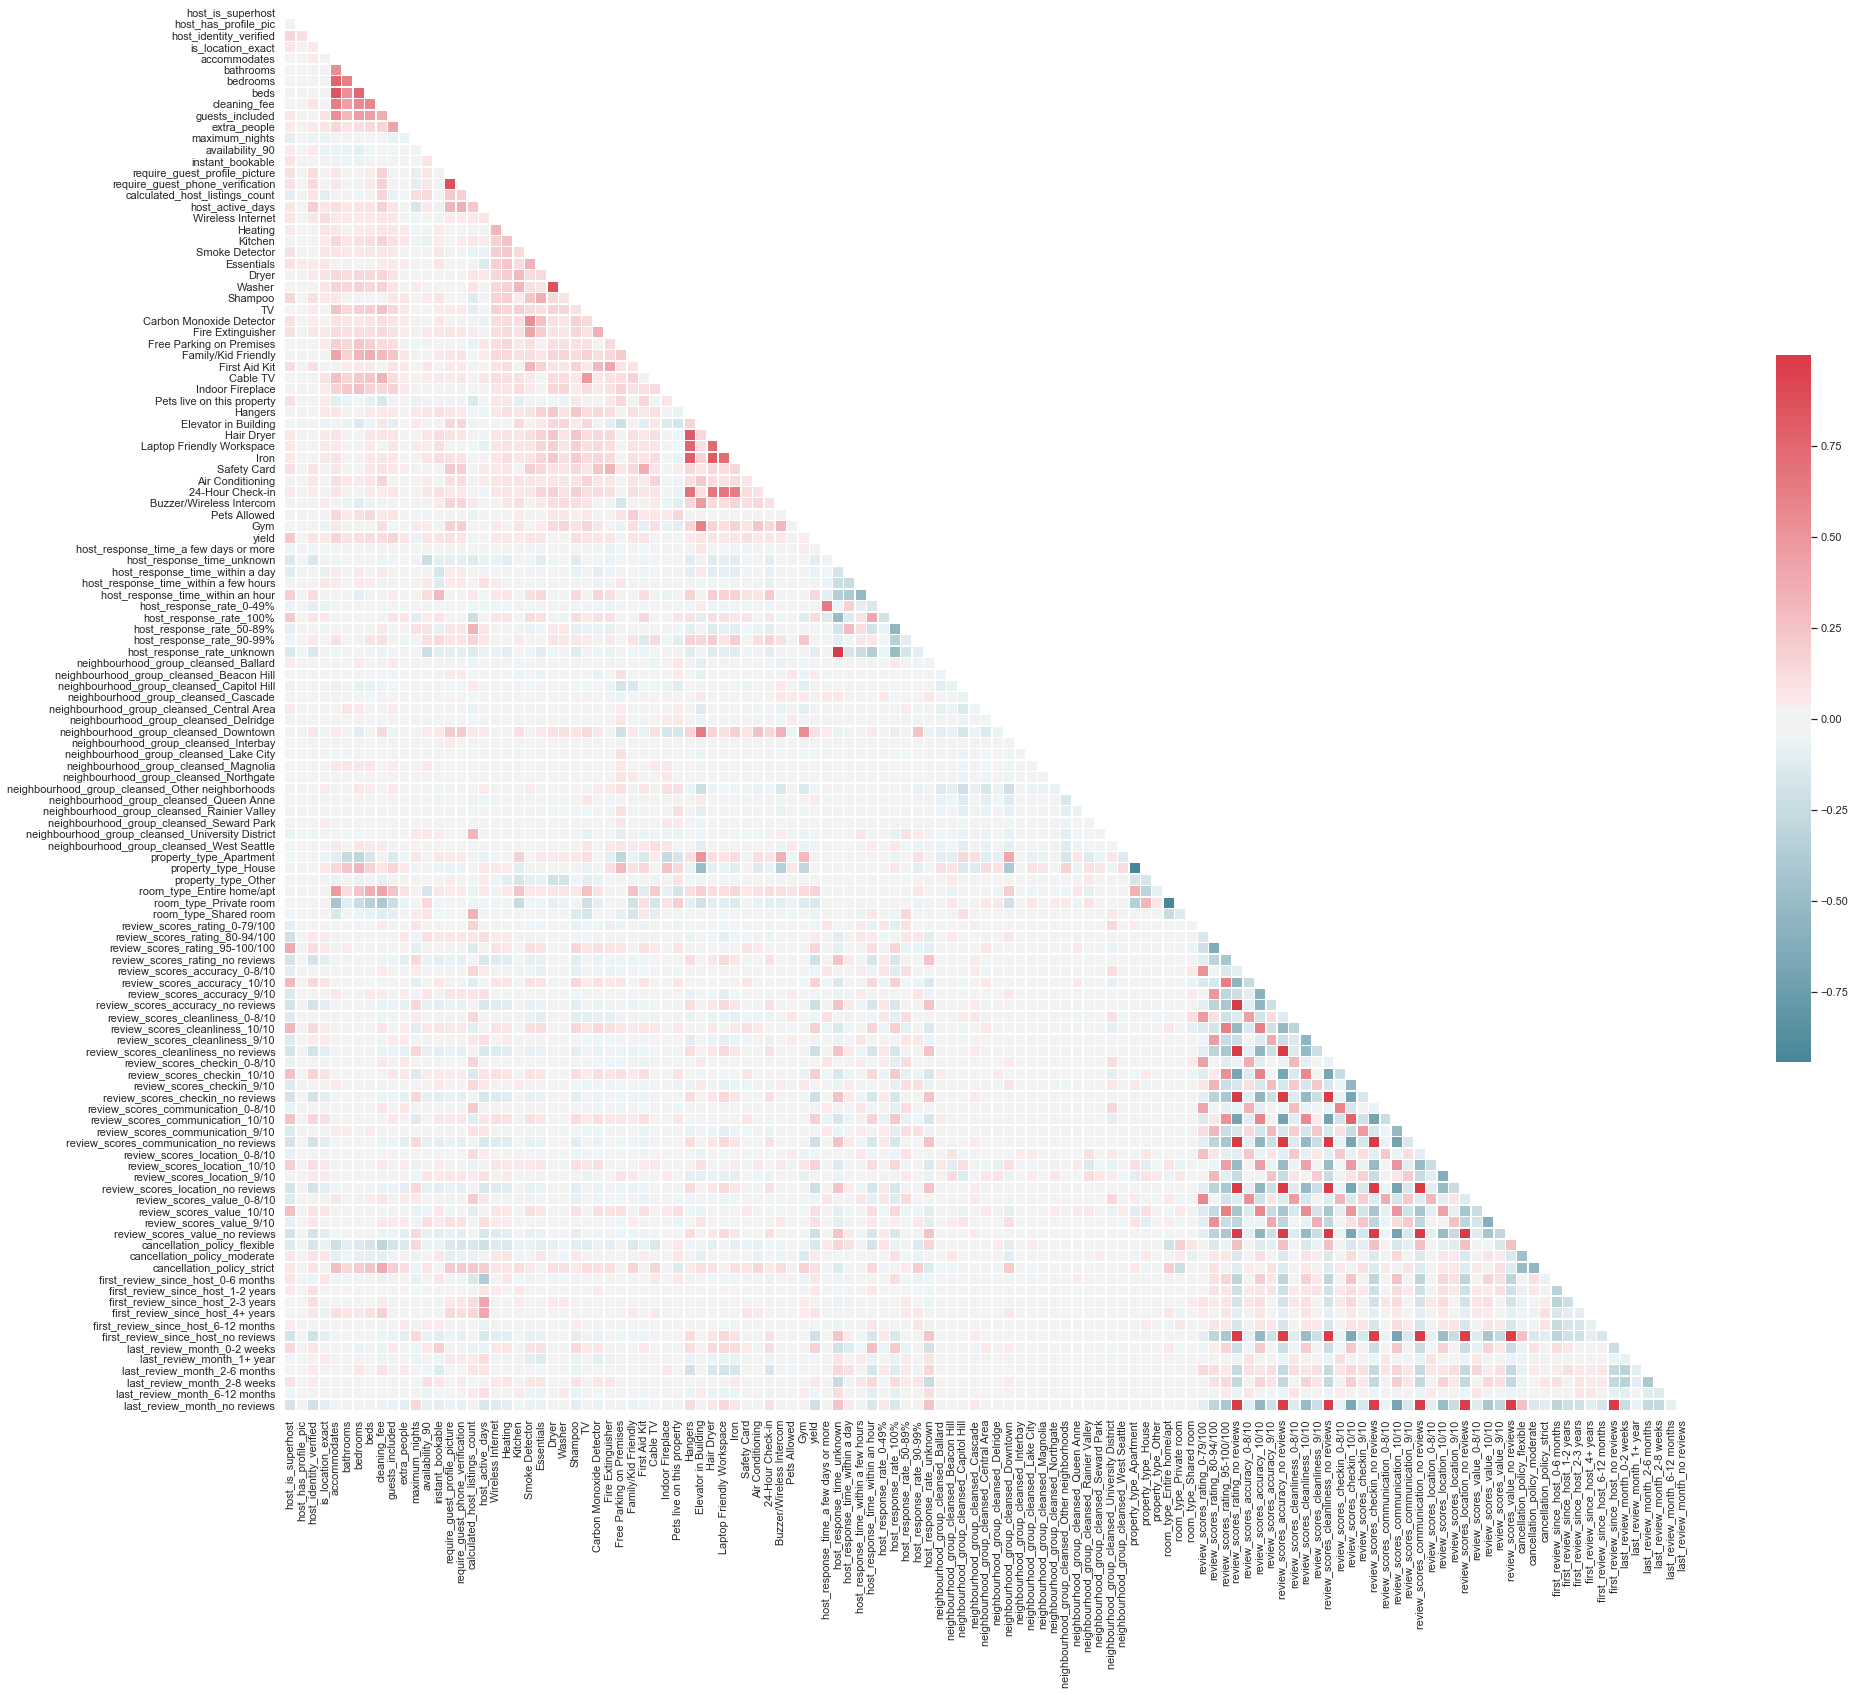

In [459]:
# check the correlation for all the features
multi_collinearity_heatmap(transformed_listings, figsize=(28,26))

> we have spot some highly correalted region above, then we will zoom in the area with highly correlated features.

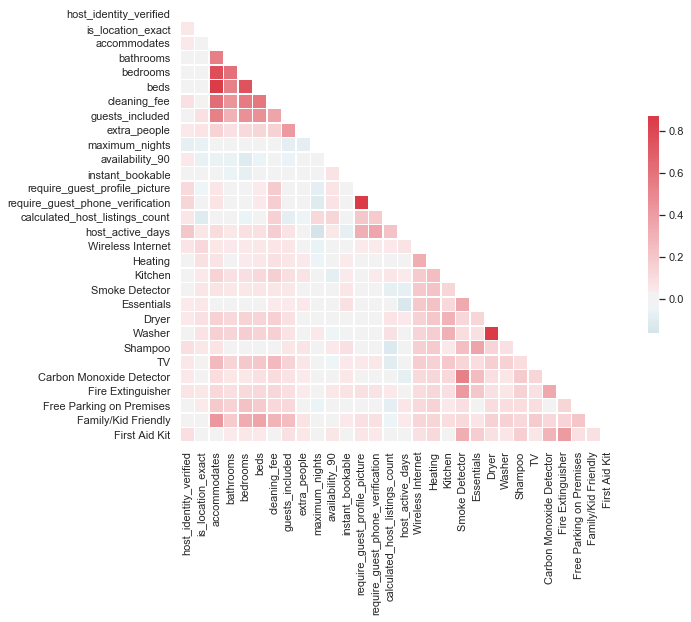

In [74]:
# Zone 1 check
multi_collinearity_heatmap(transformed_listings.iloc[:,2:32], figsize=(12,8))

>> __Zone 1 zoom-in__:
- The first area we should focus on highly-correlated features `accommodates`, `bathroom`, `beds`, `cleaning_fee` and `guests_included`.
- When we use the Airbnb App, the very important feature is how many guests the listing can accommodate, which is a top feature that a guest cares about when choosing a place to stay, so this should be an important feature for yield prediction. Hence, we will keep `accommodates` and  `cleaning fee`.
- Also, we will only keep one of `require_guest_phone_verification` and `require_guest_profile_picture`, both of them indicate the response engagement of a host, from the exploratory data analysis, we already knew that a more response a host is, the more money he can earn. 

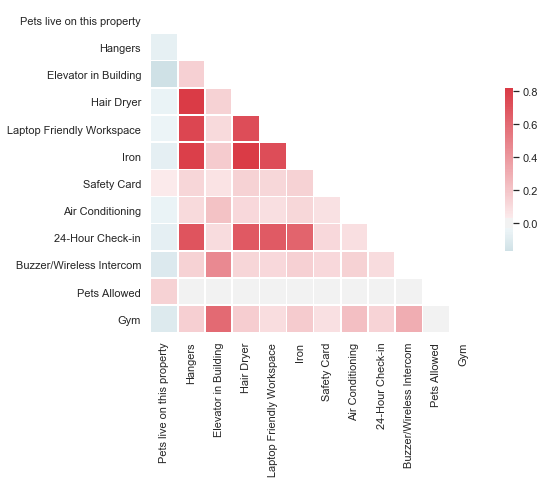

In [75]:
# Zone 2 
multi_collinearity_heatmap(transformed_listings.iloc[:,34:46], figsize=(10,6))

>> __Zone 2 zoom-in__: 
<br>Some amenities are highly correlated, such as `Hair Dryer`, `Hangers`, `Laptop Friendly workspace`, `Iron` and `24-Hour Chech-In`, we will drop the `Hangers` and `Iron`.

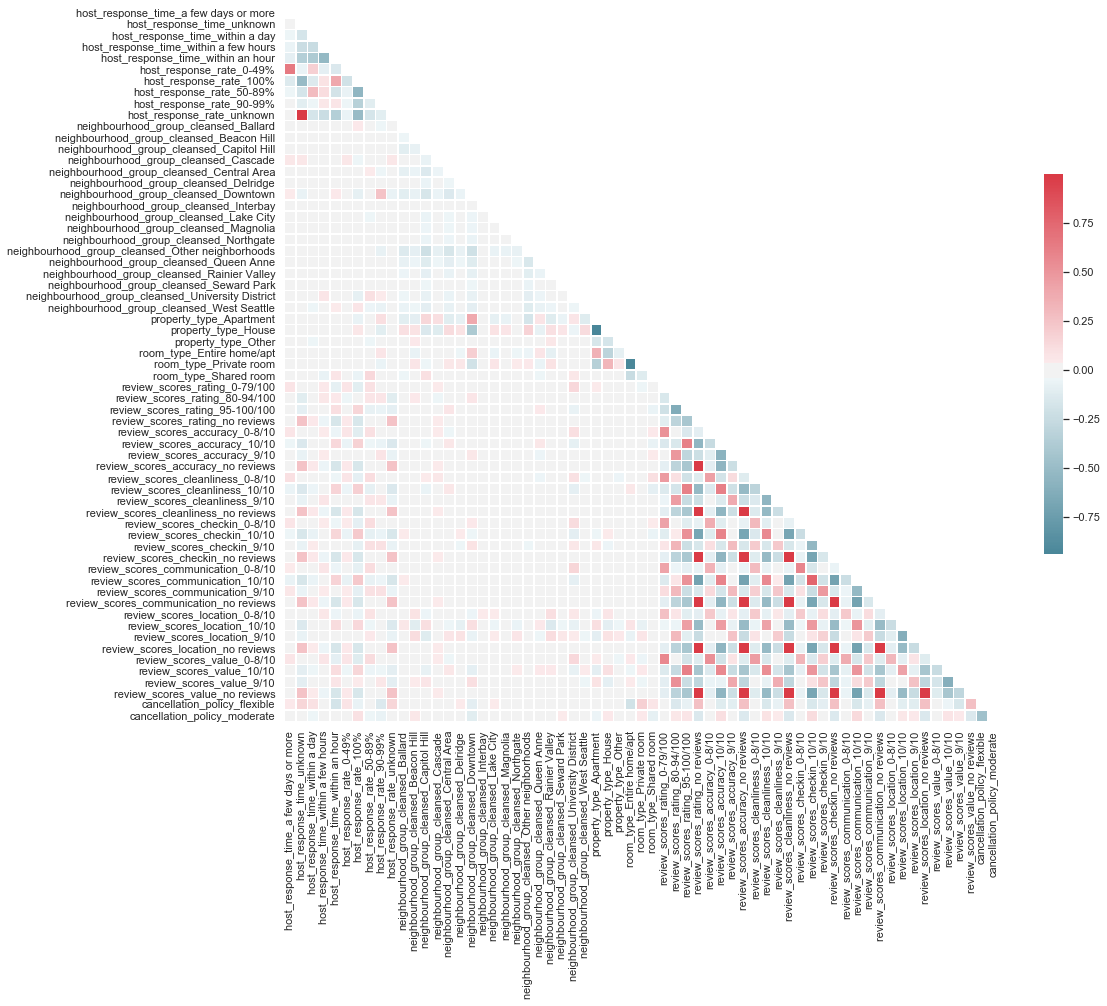

In [76]:
# Zone 3
multi_collinearity_heatmap(transformed_listings.iloc[:,47:110], figsize=(16,14))

>> __Zone 3 zoom-in__:
<br> - Unsuerpisingly, all the `no_review` for rating features are highly correlated, and we will drop all of them.
<br> - The same `no_review` features of host response rate/time are highly correlated, so one of them will be dropped.
<br> - `property_type_house` and `proterty_type_apartment` have high negative correlation, so are `room_type_private room` and `room_type_Entire_home/apartment`, each one of them will be dropped.

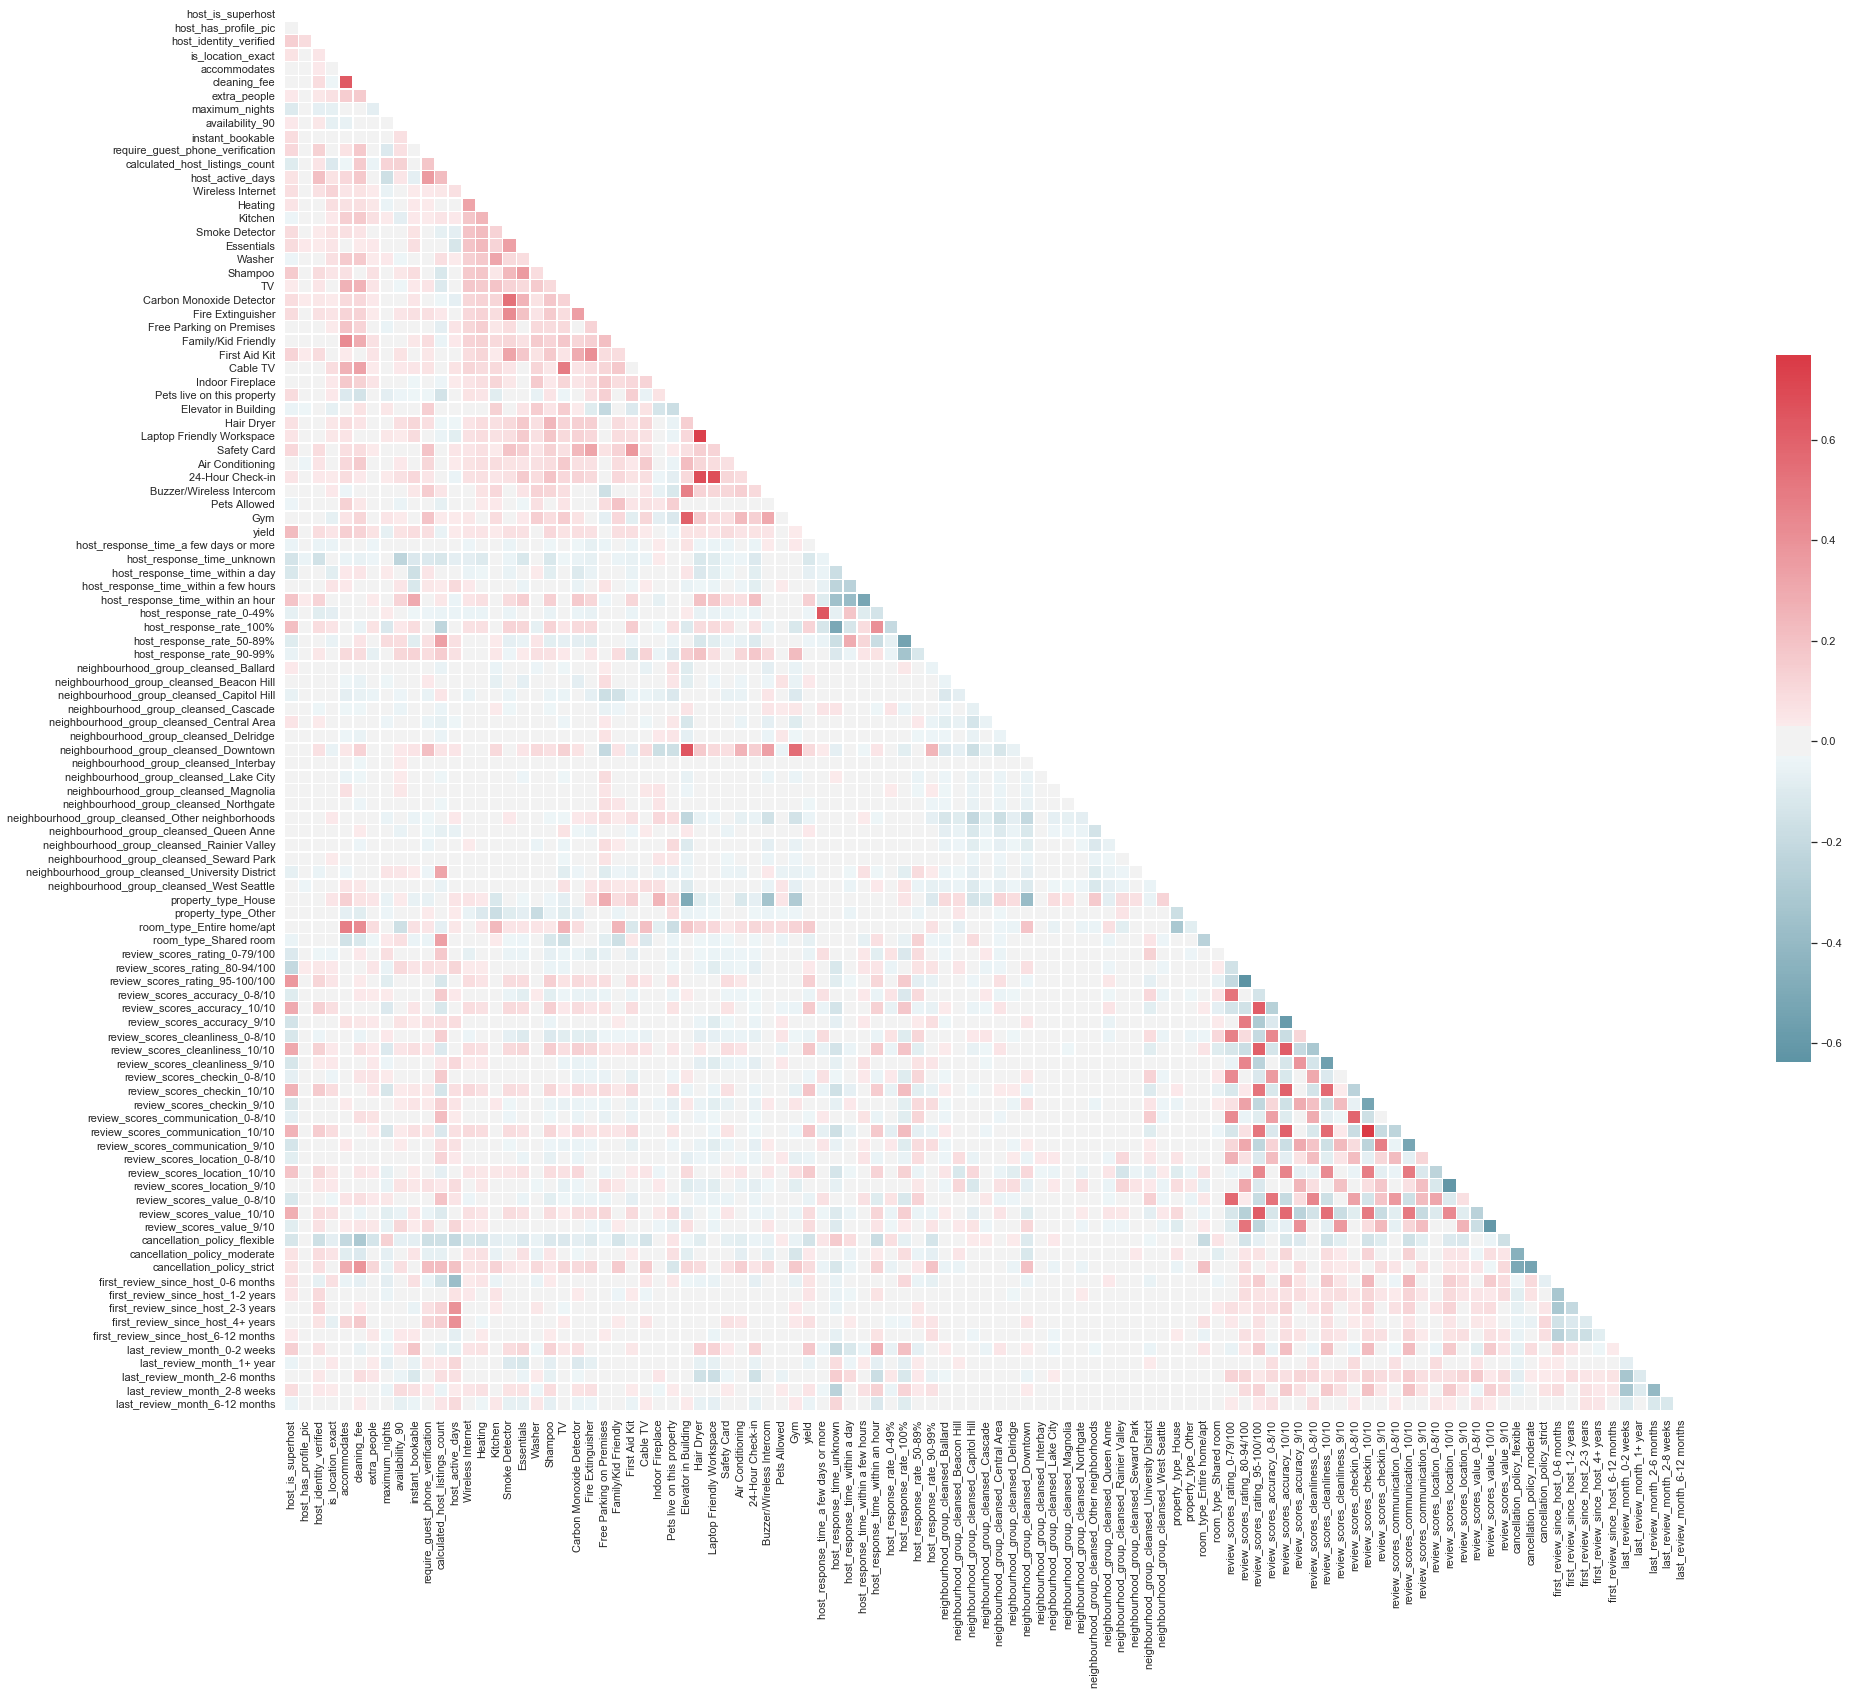

In [476]:
# Drop highly correlated features
drop_list = ['bathrooms', 'beds', 'guests_included', 'Dryer', 'bedrooms', 'require_guest_profile_picture', 'Hangers', 
             'Iron', 'host_response_rate_unknown', 'property_type_Apartment', 'room_type_Private room']
drop_list.extend(list(transformed_listings.columns[transformed_listings.columns.str.endswith('no reviews')]))

transformed_listings.drop(drop_list, axis=1, inplace=True)

# Check the results after dropping
multi_collinearity_heatmap(transformed_listings, figsize=(28,26))

## 2.2 Normalising & Standardising
<a id="sn"> </a><br>
__Normalising Features__<br>
we will apply log transformation for numerical features that are postively skewed first.

__Standardising/Scaling Features__<br>
The second step to take before we can build models is to rescale the features. This is necessary because features are in different units, and we want to unify the features so the units do not affect the algorithm. Linear Regression and Random Forest do not require feature scaling, whereas support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms.

There are two ways to scale features, __MinMaxScaler__ and __StandardScaler__ from sklearn. In our case, we will apply the first one on our data. when we train the scaling object, we want to use only the training set and we will rescale both the training set and the testing set using only training scaling parameters to prevent leaking.

### Normalising

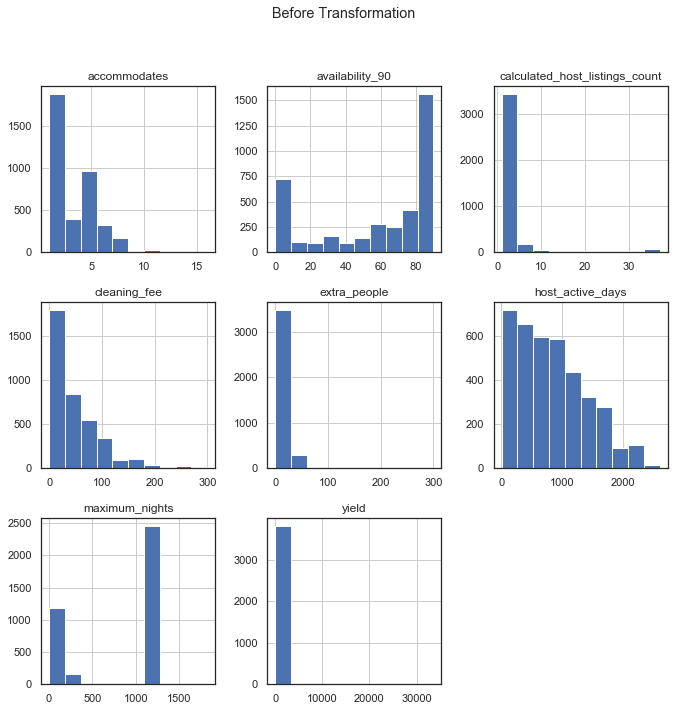

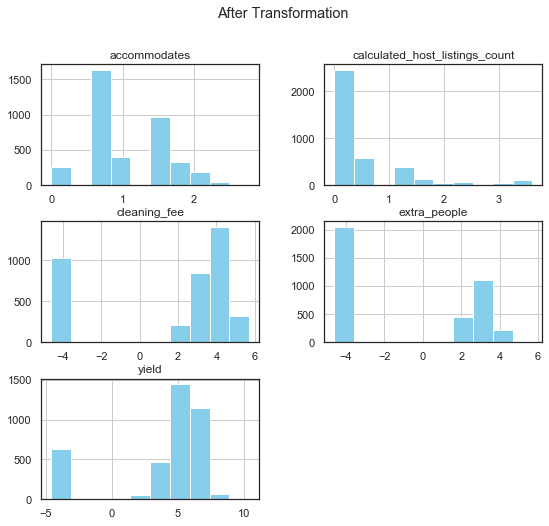

In [477]:
# Get the numerical data
numerical_columns = ['accommodates', 'cleaning_fee', 'extra_people', 'maximum_nights', 
                     'availability_90', 'calculated_host_listings_count', 'host_active_days',
                     'yield']
# Plot the raw data 
transformed_listings[numerical_columns].hist(figsize=(10,11))
plt.suptitle('Before Transformation')
plt.show()

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_active_days', 'maximum_nights']]                                                  

# Removing items not to be transformed
for col in numerical_columns:
    transformed_listings[col] = transformed_listings[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_listings[col] = np.log(transformed_listings[col])
    
# Print the results after transformation
transformed_listings[numerical_columns].hist(figsize=(8, 8), color = 'skyblue');
plt.suptitle('After Transformation')
plt.show()

### Scaling Features

In [478]:
# Separating X and y
X = transformed_listings.drop('yield', axis=1)
y = transformed_listings['yield']

# train, test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

# use standard scaler on trainset
scaler = StandardScaler()
train_X = scaler.fit_transform(X_train)

# use train scaler parameter on the test dataset
test_X = scaler.transform(X_test)


# 3 Evaluating and Comparing Machine Learning Models
<a id="ecml"> </a>

## 3.1 Models to Evaluate
<a id="me"> </a>

We will compare five different machine learning models using the Scikit-Learn library:

- Linear Regression
- Support Vector Machine Regression
- Random Forest Regression
- Gradient Boosting Regression
- K-Nearest Neighbors Regression


To compare the models, we are going to be mostly using the Scikit-Learn defaults for the model hyperparameters. And in this section, we will focus on these models' baseline performance on our dataset generally instead of optimizing the model with a determined model to use. Then we can select the best performing model for further optimization using hyperparameter tuning. 

Here is what the Scikit-learn documentation says about the defaults:

`__Sensible defaults__: Whenever an operation requires a user-defined parameter,
an appropriate default value is defined by the library. The default value
should cause the operation to be performed in a sensible way (giving a baseline
solution for the task at hand.)`


Linear Regression Performance on the test set: MAE = 0.5868
Support Vector Machine Regression Performance on the test set: MAE = 2.7581
Random Forest Regression Performance on the test set: MAE = 0.5236
Gradient Boosted Regression Performance on the test set: MAE = 0.5924
K-Nearest Neighbors Regression Performance on the test set: MAE = 2.5328


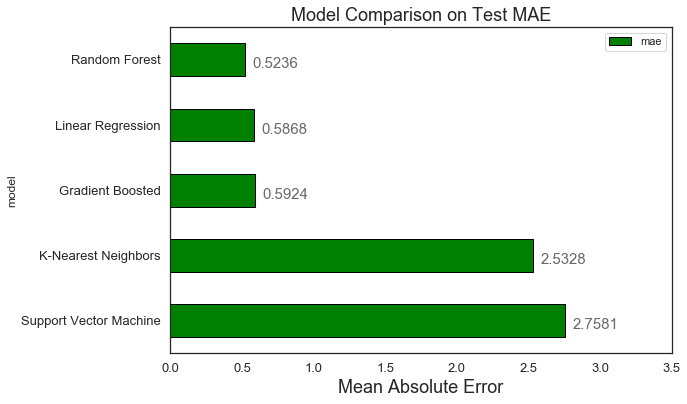

In [483]:
# define basic function to use
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performanc
    return model_mae

# Fit five different model
# linear regression
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

# support vector machine
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

# random forest
random_forest = RandomForestRegressor(random_state=42)
random_forest_mae = fit_and_evaluate(random_forest)

# gradient boost
gradient_boost = GradientBoostingRegressor(random_state=42)
gradient_boost_mae = fit_and_evaluate(gradient_boost)

# KNN
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

# print the results
print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)
print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)
print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)
print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boost_mae)
print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

# Plot the Mae for five model
ax = model_comparison.sort_values('mae', ascending = True).plot(x = 'model', y = 'mae', kind='barh', figsize=(8,6), 
                                                                 color="green",  edgecolor = 'black', fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Model Comparison on Test MAE", fontsize=18)
ax.set_xlabel("Mean Absolute Error", fontsize=18)
ax.set_xlim(0,3.5)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.05 , i.get_y()+.38, str(round(i.get_width(), 4)), fontsize=15, color='dimgrey')

# invert for largest on top 
ax.invert_yaxis()


Depending on the run above, the `random forest`,`linear regression` and `gradient boost` return the best results among the five models.
From here, we are going to concentrate on optimizing the best model using hyperparameter tuning. Given the results here, we will start from `random forest` and explore `linear regression` later.

## 3.2 Model Optimization
<a id="mo"> </a>
In machine learning prediction, optimizing a model will find us the best set of hyperparameters for to achieve the best performance. we will start with the random forest first.

### 3.2.1 Hyperparameters
<a id="h"> </a>
<br>
In our case of a random forest, hyperparameters include,

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

The best hyperparameters are usually impossible to determine before training, which means the best practice to determine the optimal settings is to try many different combinations to evaluate the performance of each model. However, evaluating each model only on the training set can cause overfitting - which means our model will score very well on the training whereas it will not be able to generalize to new data as good as we expected.

Hyperparameter Tuning with Random Search within Cross Validation will generate more reliable results for our reference.

In our case, we will use Random Search with cross validation to explore where the model can have relatively good performance, once we narrow down the options and then use the grid search with a more limited range of options for the best model.

The K-Fold Cross Validation technique dividing the training data into K folds, and then going through an iterative process on each K-1 fold data set and evaluate performance on the kth fold. Average error on each of the K iterations as the final performance will be computed as the given results.

The next section will demonstrate how we use __random search__ to narrow down the scope and use __grid search__ to find our best model, with the combination of cross validation.


#### Random Hyperparameter Grid

In [83]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 41.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [487]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(rf_random.cv_results_).sort_values('mean_test_score', ascending = False)
#random_results.head()
print("best parameters by random search:{} \n".format(rf_random.best_params_))

# define the evaluation matrix
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))    
    return accuracy


# fit a base model
print("Bese Model")
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print()
print("Best Random Search Model")
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

best parameters by random search:{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

Bese Model
Model Performance
Average Error: 0.5551 degrees.
Accuracy = 88.93%.

Best Random Search Model
Model Performance
Average Error: 0.5400 degrees.
Accuracy = 89.43%.
Improvement of 0.56%.


#### Grid Search with Cross Validation

In [499]:

# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

# Create a based model
rf = RandomForestRegressor(min_samples_split = 2, 
                           min_samples_leaf  = 1,
                           max_features = 'sqrt',
                           max_depth  = None, 
                           bootstrap = False)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3, 
                           #n_jobs = -1, 
                           verbose = 2, 
                           return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# print the best model parameters from grid search
print("best parameters by grid search:{}\n".format(grid_search.best_params_))

# refit the model with best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

# Print the accuracy
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   1.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   1.2s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   0.8s
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=   1.1s
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=   1.3s
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=   1.3s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   1.4s
[CV] n_estimators=200 ................................................
[CV] ................................. n_estimators=200, total=   1.4s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.8min finished


best parameters by grid search:{'n_estimators': 800}

Model Performance
Average Error: 0.5388 degrees.
Accuracy = 89.46%.
Improvement of 0.59%.


Text(0.5, 1.0, 'Performance vs Number of Trees')

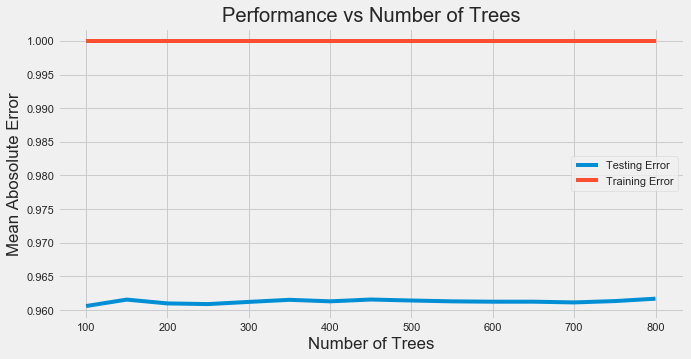

In [505]:
plt.style.use('fivethirtyeight')
plt.figure(figsize= (10,5))
plt.plot(results['param_n_estimators'], results['mean_test_score'], label = 'Testing Error',)
plt.plot(results['param_n_estimators'], results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Abosolute Error')
plt.legend();
plt.title('Performance vs Number of Trees')

From this plot, it's pretty clear that our model is not overfitting. The training error is lower than the testing error, however, it is fairly close - which shows that the model is learning the training data very well and is also able to generalize to the test data as well. Moreover, as the number of trees increases, the test error looks flat, we might have already achieved very good performance with other best parameters from the random search, the increase in the number of trees won't help us to improve further.

### 3.2.2 Feature Reduction
<a id="fr"> </a>
To avoid the curse of dimentionaity, we will extract the top importance features to refit the model.

we will first take a look at the top important features, then we will use the feature within 95% importance to refit the model, to see if there's any improvement for our data.

                                feature  importance
0     review_scores_communication_10/10    0.135638
1           review_scores_checkin_10/10    0.106448
2          review_scores_accuracy_10/10    0.065289
3        review_scores_rating_80-94/100    0.062521
4          review_scores_location_10/10    0.060830
5       review_scores_cleanliness_10/10    0.059528
6              review_scores_value_9/10    0.043316
7          last_review_month_2-6 months    0.034983
8       review_scores_rating_95-100/100    0.032949
9           review_scores_location_9/10    0.030570
10          last_review_month_2-8 weeks    0.027638
11          review_scores_accuracy_9/10    0.027623
12   first_review_since_host_0-6 months    0.026890
13            review_scores_value_10/10    0.025760
14       review_scores_cleanliness_9/10    0.025703
15           review_scores_checkin_9/10    0.024743
16     review_scores_communication_9/10    0.023168
17           review_scores_value_0-8/10    0.017642
18          

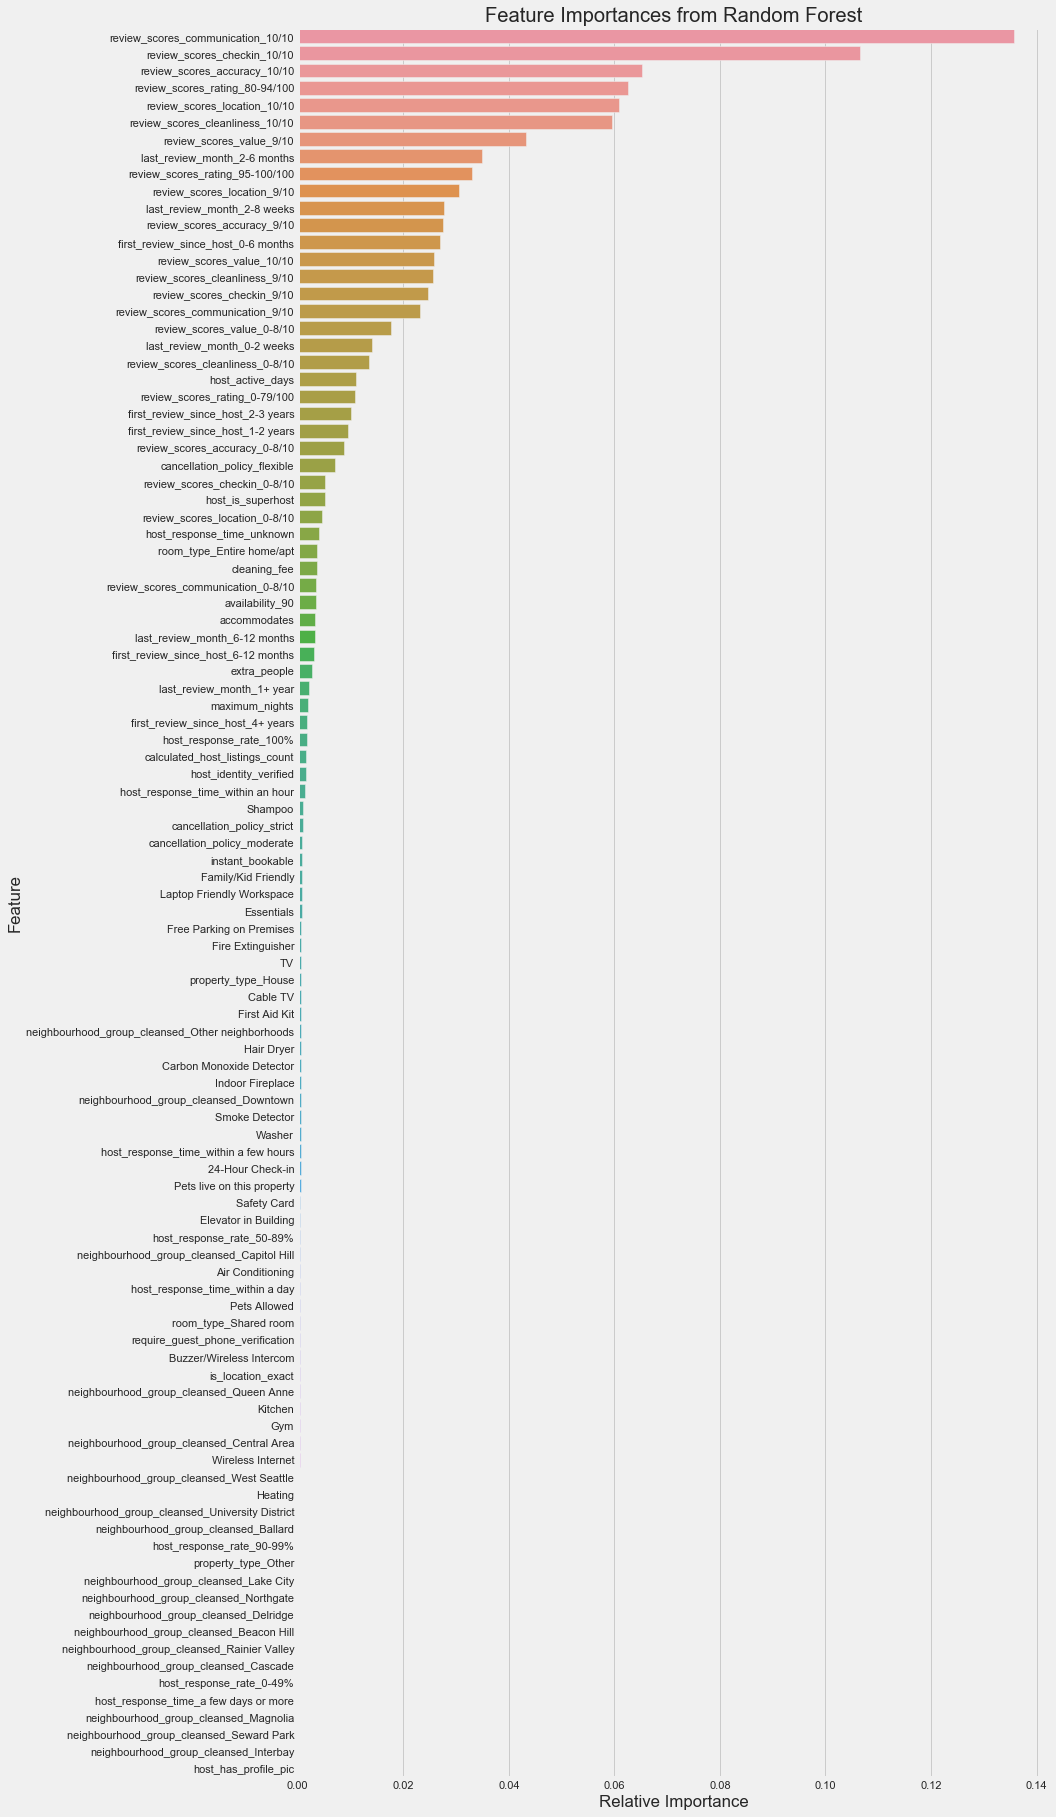

In [508]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(X_train.columns), 
                                'importance': best_grid.feature_importances_})

# Show the top 50 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
print(feature_results.head(50))

#plot the feature imortance
plt.figure(figsize=(12, 30))
sns.barplot(x='importance', y='feature', 
            data=feature_results)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.show()

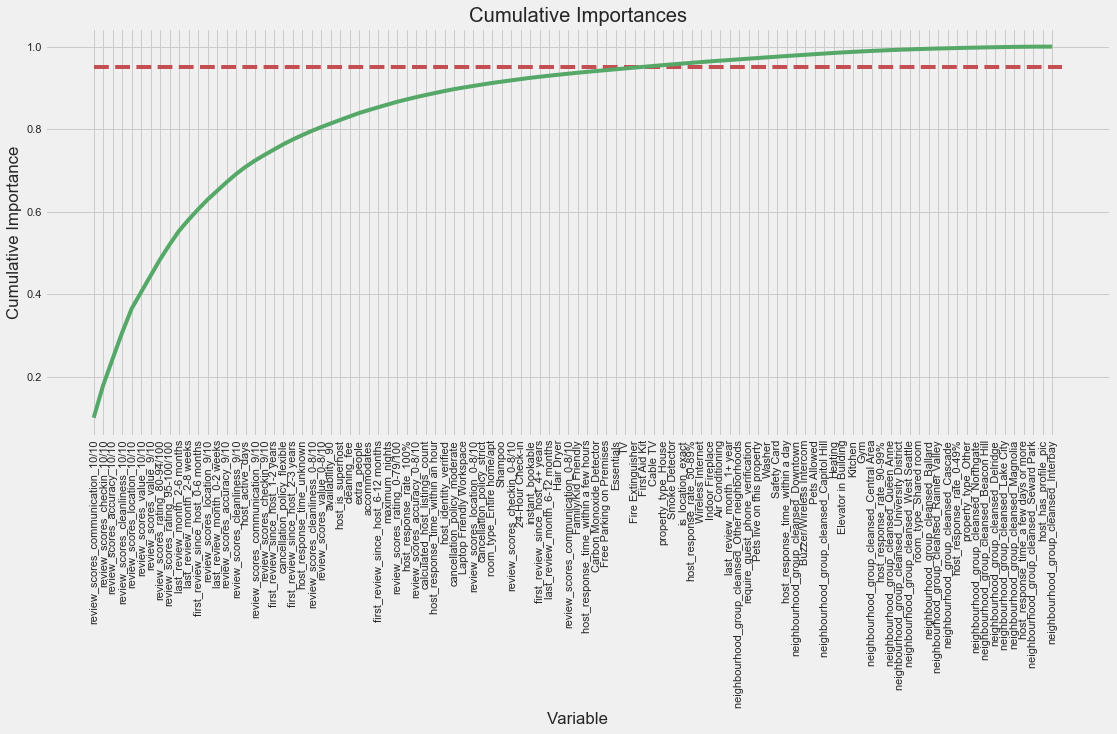

In [135]:
# get index
x_values = list(feature_results.index)
# get importance
sorted_importances = list(feature_results.importance)
# get the correspond feature
sorted_features = list(feature_results.feature)
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)


#Plot the cumulative importance
plt.figure(figsize = (17,7))
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')
plt.show()


In [509]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

# Extract the names of the most important features
important_feature_names = list(feature_results[0:58].feature)
# Find the columns of the most important features
feature_list = list(X_train.columns)
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_train_features = X_train.iloc[:, important_indices]
important_test_features = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)


# Instantiate random forest and train on new features
rf_imp = RandomForestRegressor(n_estimators = 800, 
                               min_samples_split = 2, 
                               min_samples_leaf  = 1,
                               max_features = 'sqrt',
                               max_depth  = None, 
                               bootstrap = False,
                               random_state=42)
rf_imp.fit(important_train_features, y_train)

# Make predictions on test data
predictions = rf_imp.predict(important_test_features)
# Performance metrics
errors = abs(predictions - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))

# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')
print('Improvement of {:0.2f}%.'.format( 100 * (accuracy- base_accuracy) / base_accuracy))

Number of features for 95% importance: 59
Important train features shape: (3054, 58)
Important test features shape: (764, 58)
Average absolute error: 0.54 degrees.
Accuracy: 89.38 %.
Improvement of 0.51%.


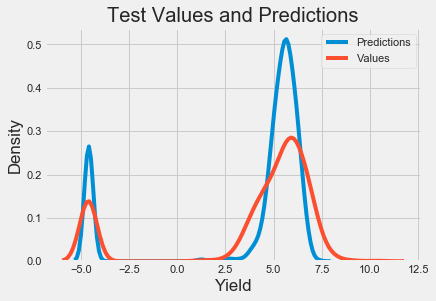

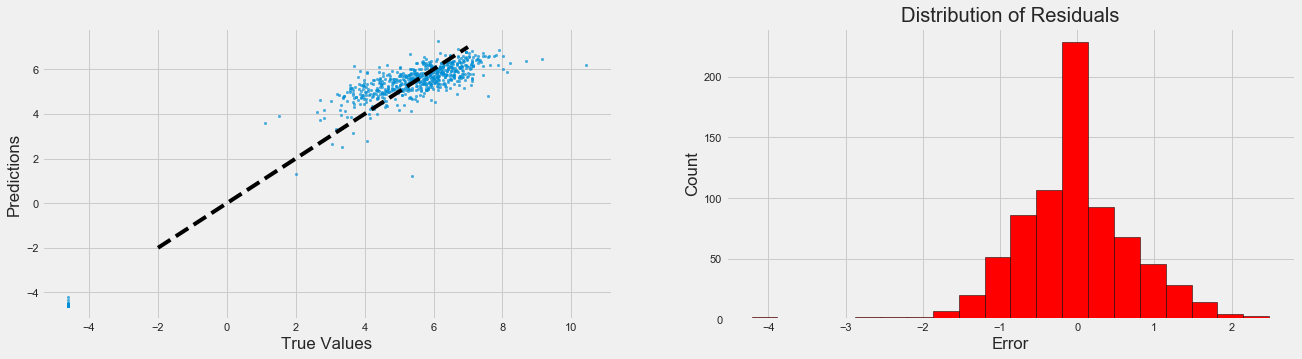

In [511]:
def results_plot(predictions, y_test):
    # Prediction density plot
    sns.kdeplot(predictions, label = 'Predictions')
    sns.kdeplot(y_test, label = 'Values')
    # Label the plot
    plt.xlabel('Yield')
    plt.ylabel('Density')
    plt.title('Test Values and Predictions')
    plt.show()
    
    fig, axes = plt.subplots(1, 2, sharey=False, tight_layout=False, figsize=(20,5))
    axes[0].scatter(y_test, predictions,  s=6, alpha=0.7)
    axes[0].plot(list(range(-2,8)), list(range(-2,8)), color='black', linestyle='--')
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predictions')

    residuals = predictions - y_test
    # Plot the residuals in a histogram
    axes[1].hist(residuals,  color = 'red', bins = 20,edgecolor = 'black')
    axes[1].set_xlabel('Error')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Residuals')
    plt.show()
    
results_plot(predictions, y_test)

We visualize the random forest with the reduced features, it turns out the model is very good. However, we can see we have some overprediction compared to the true values.

We can see that the random grid search returns the best parameter, with refit using that best parameter returns better model than the default mode, and beyond that, we use grid search with cross-validation with a smaller parameter range and returns the best model above all, and the model with feature reduction returns a model with improvement compared with the base model. however, the three optimized models show similar performance.


   Model                                           |   Accuracy   |   Improvement(to base model)
-------------------------------------------------- | -------------| -----------------------------
Base Model                                         | 88.93%       |  - 
Best Model with Random Grid Search                 | 89.43%       |  0.56%
Best Model with Grid Search & Cross Validation     | 89.46 %      |  0.59%
Model with Reduced Features                        | 89.38 %      |  0.51%

With the rule as always stick the __parsimonious model__, we would choose the __random forest__ as our best model for now.
Further, we would like to use the reduced features with the linear regression model, given that rules we mentioned before, also we take its good performance from the baseline linear regression model into account as well.

#### Linear Regression

In [516]:
# define evaluation metrix calculator
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

# fit a simple linear regression
reg = LinearRegression()
reg.fit(important_train_features, y_train)
linear_predictions = reg.predict(important_test_features)

train_error, test_error = calc_metrics(important_train_features, y_train, important_test_features, y_test,reg)
train_error, test_error = round(train_error, 3), round(test_error, 3)
print("Linear regression with reduced features:")
print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

base_accuracy = reg.score(important_test_features, y_test)
print('Accuracy:', round(base_accuracy*100, 2), '%.')

###############################################################

# Use 5 fold cross validation to see how to model generalize
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
print()
print("Cross Validation results: ")
train_errors = []
validation_errors = []
for train_index, val_index in kf.split(important_train_features, y_train):

    # split data
    X_train_new, X_val_new = important_train_features.iloc[train_index], important_train_features.iloc[val_index]
    y_train_new, y_val_new = y_train.iloc[train_index], y_train.iloc[val_index]

    # instantiate model
    reg = LinearRegression()

    #calculate errors
    train_error, val_error = calc_metrics(X_train_new, y_train_new, X_val_new, y_val_new, reg)

    # append to appropriate list
    train_errors.append(train_error)
    validation_errors.append(val_error)
    print("Train Error:{:14f} | Test Error:{:16f}".format(train_error, val_error ))
    
    # generate report
print('mean(train_error): {:7} | mean(val_error): {:16f}'.format(round(np.mean(train_errors),4),round(np.mean(validation_errors),4)))

Linear regression with reduced features:
train error: 0.549 | test error: 0.584
train/test: 1.1
Accuracy: 96.08 %.

Cross Validation results: 
Train Error:      0.552568 | Test Error:        0.545886
Train Error:      0.530577 | Test Error:        0.633760
Train Error:      0.548945 | Test Error:        0.565060
Train Error:      0.546624 | Test Error:59045546667624224.000000
Train Error:      0.552279 | Test Error:38963401287634640.000000
mean(train_error):  0.5462 | mean(val_error): 19601789591051772.000000


The simple linear regression has a very good performance, however, the cross-validation results show that the model cannot hold it when it comes to generalizing.  We will add regularization term into the linear model to see if it can be improved.

#### Linear Regression with regulization

Ridge Regression with Cross Validation: 
alpha: 0.0001 | mean(train_error):  0.5462 | mean(val_error): 0.5755
alpha:  0.001 | mean(train_error):  0.5462 | mean(val_error): 0.5755
alpha:   0.01 | mean(train_error):  0.5463 | mean(val_error): 0.575
alpha:    0.1 | mean(train_error):  0.5481 | mean(val_error): 0.5757
alpha:      1 | mean(train_error):  0.5683 | mean(val_error): 0.5972
alpha:   10.0 | mean(train_error):  0.6824 | mean(val_error): 0.7163
best alpha: 0.0001


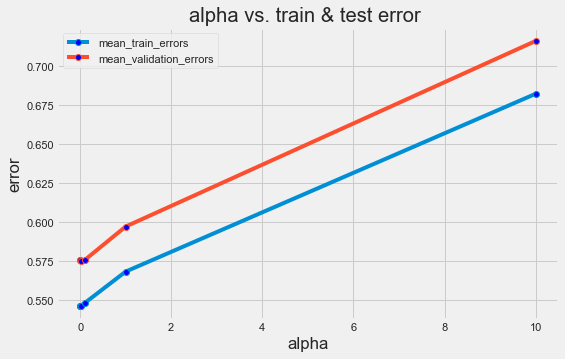

In [519]:
# Initial ridge regression 

# set regulization term
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
# Kflod cross validation
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
print("Ridge Regression with Cross Validation: ")
mean_train_errors = []
mean_validation_errors = []
for alpha in alphas:
    train_errors = []
    validation_errors = []
    for train_index, val_index in kf.split(important_train_features, y_train):       
        # split data
        X_train_new, X_val_new = important_train_features.iloc[train_index], important_train_features.iloc[val_index]
        y_train_new, y_val_new = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # instantiate model
        ridge = Ridge(alpha=alpha, fit_intercept=True, random_state=77)
        
        #calculate errors
        train_error, val_error = calc_metrics(X_train_new, y_train_new, X_val_new, y_val_new, ridge)
        
        # append to appropriate list
        train_errors.append(train_error)
        validation_errors.append(val_error)
        
    mean_train_error = round(np.mean(train_errors),4)
    mean_validation_error = round(np.mean(validation_errors),4)
    mean_train_errors.append(mean_train_error)
    mean_validation_errors.append(mean_validation_error)
        
     # generate report
    print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.format(alpha,round(np.mean(train_errors),4),round(np.mean(validation_errors),4)))
    
    
print('best alpha: {}'.format(alphas[np.argmin(validation_errors)]))

#####################
# visualize the regulization performance
train_test_error = pd.DataFrame({"alpha": alphas,
                                 "mean_train_errors":mean_train_errors,
                                 "mean_validation_errors": mean_validation_errors})

#plt.style.use('fivethirtyeight')
train_test_error.plot(x='alpha', marker = 'o', markerfacecolor='blue',figsize= (8,5))
plt.ylabel('error')
plt.xlabel('alpha')
plt.title("alpha vs. train & test error ")
plt.show()


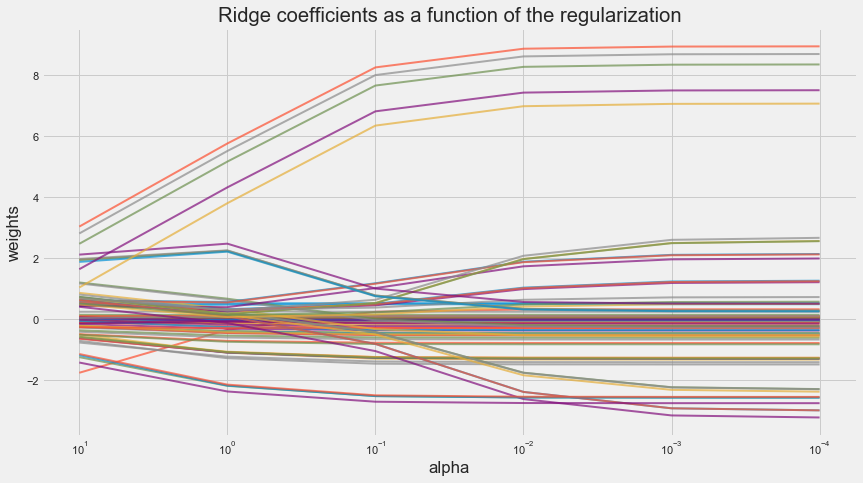

In [520]:
# visuliza the regulization
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)


# Display results
plt.figure(figsize=(13,7))
ax = plt.gca()

ax.plot(alphas, coefs, linewidth=2, alpha=0.7)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [423]:
ridge_best = Ridge(alpha=0.0001, fit_intercept=True, random_state=77)
ridge_best.fit(important_train_features, y_train)
ridge_best.predictions = reg.predict(important_test_features)
#print("mse: {:.4f}".format(np.sqrt(mean_squared_error(y_test, ridge_best.predictions))))

ridge_best_accuracy = ridge_best.score(important_test_features, y_test)
print('Ridge Accuracy: {:0.2f}%'.format(100*ridge_best_accuracy)) 
print('Improvement of {:0.2f}%.'.format( 100 * (ridge_best_accuracy- base_accuracy) / base_accuracy))

Accuracy: 95.57%
Improvement of 0.00%.


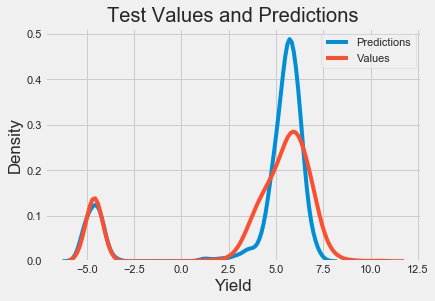

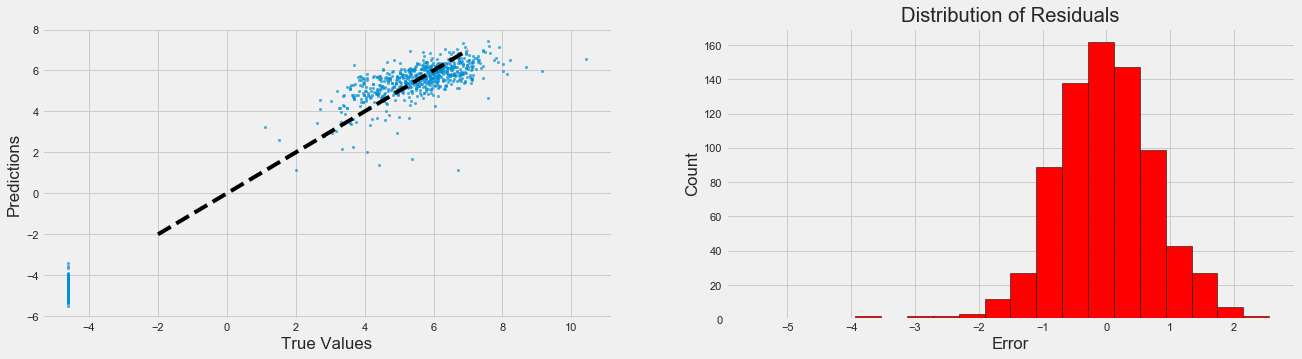

In [521]:
results_plot(ridge_best.predictions, y_test)

The linear regression and ridge have very close performance round 95% prediction accuracy. However, the linear regression does not generalize during cross-validation, so we will go with ridge regression. 
 
The ridge regularization coefficient plot above shows that the alpha = 0.0001 does not coerce the coefficient much.

Moreover, the prediction results showing that the overprediction is improved, the left peak is perfectly fitted, and the residual plot looks narrower and closer shape to the normal distribution, compared to the random forest with reduced features.

# 4. Conclusion & Recommandation
<a id="cr"> </a>
Compared to the best random forest model with an accuracy of 89.38%, the ridge regreesiom would be a better choice for predicting the yield.


   Model                                                         |   Accuracy   |   Improvement(to base model)
---------------------------------------------------------------- | -------------| -----------------------------
Model with Reduced Features	                                     |   89.38 %    |  -
Ridge Regression                                                 |   95.57 %    |  6.93%
